## Where are we?
In workbook_1 we read in the database, and clean it up. The database consists of 9.5 million products. As part of clean up we remove all books, software, movies, CD, music etc (a few other similar category of products). We also remove columns we do not need, and create a label from the "categories" column (more on this later). 

At the end (of workbook_1) we have a dataset (gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513)
that has approx. 5.6 million product entries. Columns are ['asin', 'categories', 'description', 'title', 'imUrl', 'label']. Of these, 'label' is generated from the 'categories' column.

#### Approach 1: Use the 'categories' colmn as the label
Our first thought was to use the 'categories' itself as the data label. The problem is there are nearly 90,000 unique 'categories' entries in the cleaned dataset. There is huge overlap as well, as can be expected. For comparison the google taxonomy has approximately 5600 categories.

#### Approach 2: Derive label from the categories (workbook_2)
Second approach was to derive the label from the 'categories'. The assumption was that the 'categories' entires are labels, but we want a smaller set to start with. The following example illustrates how we derived the label:

    categories entry: 'Musical Instruments, Instrument Accessories, General Accessories, Sheet Music Folders'
    label derived: 'Musical Instruments'

We picked the first string as the label, assuming a comma separated list of strings.

This results in a total of 35 unique labels. We ran the dataset through a resnet34 model, got an error rate of 0.71 

A little digging shows two issues:
* There are multiple similar labels. 
    Example: we have three labels: 'Beauty', 'Luxury Beauty", and 'All Beauty'.
    A possible way forward is to combine these. This will surely help but is not easily scalable because of the human element required.
    
* There are multiple "mis-labled" data. Examples are easy to see when we plot the top losses. Did some digging, and we found:
    Example: 'categories' like 'Sports & Outdoors, Other Sports, Dance, Clothing, Girls, Skirts'. 
    The derived 'label' from this would be 'Sports & Outdoors', but the image is a skirt.

This suggests that the enties in 'categories' should be treated as multiple categories in a multi-category dataset (which this arguably is), or possibly as keywords in an un-labled dataset.

#### Approach 3: Treat dataset as an un-labled dataset. Generate labels using Platform.ai
This is the approach the original paper follows as well (https://arxiv.org/pdf/1904.09037.pdf).

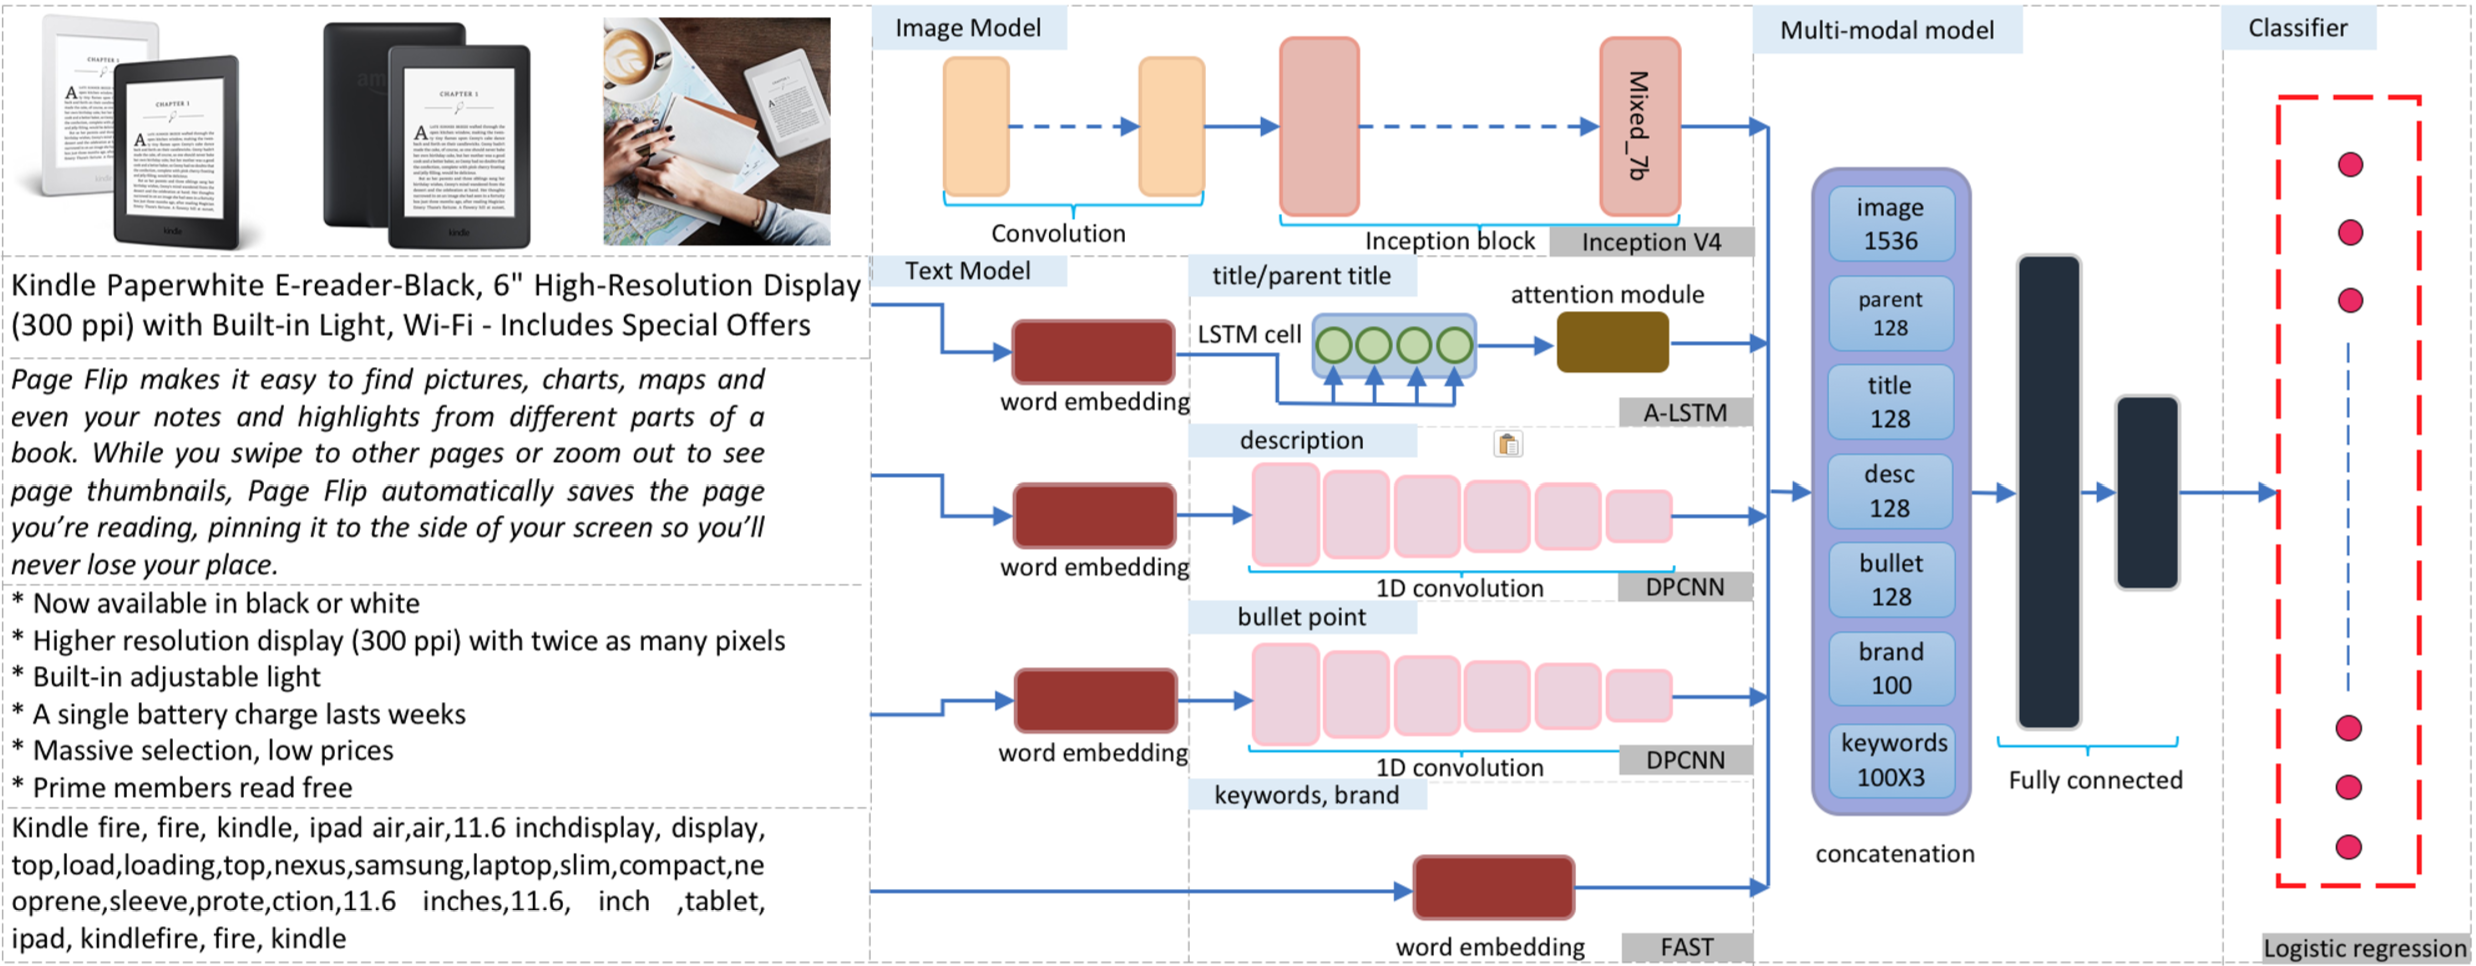

(from https://arxiv.org/pdf/1904.09037.pdf)

##### Proposed Approach
* As a starting point we intend to use only the image (first branch in figure above) and the keywords (last branch in the figure). 
* For the image we use ResNet to generate and capture the activations
* For the key words, we use FasText to generate the activations
* Concatenate the activations for each product
* Feed the activations into Platform.ai and use that to generate labels (loopy process)
